It looks like you might be running this notebook in Colab! If you want to enable GPU acceleration, ensure you select a GPU runtime in the top-right dropdown menu 🔥

# Train a model

> **FYI**, you can open this documentation as a [Google Colab notebook](https://colab.research.google.com/github/jla-gardner/graph-pes/blob/main/docs/source/quickstart/quickstart.ipynb) to follow along interactively

[graph-pes-train](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html) provides a unified interface to train any [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel), including those packaged within [graph_pes.models](https://jla-gardner.github.io/graph-pes/models/root.html), custom ones defined by you, and any of the wrapper interfaces that ``graph-pes`` provides to other machine learning frameworks.

For more information on the ``graph-pes-train`` command, and the plethora of options available for specification in your ``config.yaml`` see the [CLI reference](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html).

Below, we train a lightweight [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html) model on the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset.

## Installation


In [1]:
!pip install graph-pes

We should now have access to the ``graph-pes-train`` command. We can check this by running:

In [14]:
!graph-pes-train -h

usage: graph-pes-train [-h] [args ...]

Train a GraphPES model using PyTorch Lightning.

positional arguments:
  args        Config files and command line specifications. Config files
              should be YAML (.yaml/.yml) files. Command line specifications
              should be in the form my/nested/key=value. Final config is built
              up from these items in a left to right manner, with later items
              taking precedence over earlier ones in the case of conflicts.

optional arguments:
  -h, --help  show this help message and exit

Copyright 2023-25, John Gardner


## Data definition

When training a model, we typically want 3 sets of data (i.e. labelled atomic structures): a training set, a validation set, and a test set.

Below, we use [load-atoms](https://jla-gardner.github.io/load-atoms/) to download and split the C-GAP-17 dataset into training, validation and test datasets, and write these to `xyz` files. (``graph-pes`` supports other dataset formats too, including ``ase sqlite`` databases -- see [here](https://jla-gardner.github.io/graph-pes/data/datasets.html#useful-datasets) for more details)

In [15]:
import ase.io
from load_atoms import load_dataset

structures = load_dataset("C-GAP-17")
train, val, test = structures.random_split([0.8, 0.1, 0.1])

ase.io.write("train-cgap17.xyz", train)
ase.io.write("val-cgap17.xyz", val)
ase.io.write("test-cgap17.xyz", test)

Output()

We can visualise the kinds of structures we're training on using [load_atoms.view](https://jla-gardner.github.io/load-atoms/api/viz.html):


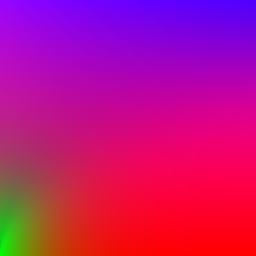

In [16]:
from load_atoms import view

view(train[0], show_bonds=True)

As you can see, each structure has an ``energy`` label:

In [17]:
train[0].info["energy"]

-5643.968171

... as well as a ``forces`` label (one for each atom in the structure):

In [19]:
train[0].arrays["forces"].shape

(36, 3)

These properties are stored in the files we have just created:

In [20]:
!head train-cgap17.xyz

36
Lattice="6.439806 0.0 0.0 0.0 6.439806 0.0 0.0 0.0 8.586408" Properties=species:S:1:pos:R:3:forces:R:3 config_type=bulk_amo detailed_ct=iter4_2 split=train energy=-5643.968171 pbc="T T T"
C      -10.19681458       4.52108512       2.58260263       1.92054269       0.70905554       3.23398419
C        8.88245018      10.54923296       9.85602863      -8.61008207       4.76824471      10.54597273
C      -12.37947091       3.12898582       0.00437048       0.40437923      -0.84438408       0.64039651
C      -15.36751513       3.67112089       7.46005158      -2.19558355      -5.72081017     -10.70417213
C        1.48348659       8.44603096      -5.40849254       2.13894508      -3.77202448       2.30942937
C        6.68203286       2.50162636     -11.97770429       0.95262647      -0.03136726      -0.79207429
C      -15.10503508       0.29261834       6.90345486      -2.22105290       2.34675963      -6.38519060
C       -4.49987240       0.25155170      -7.21023863       0.27927988    

## Configuration

Now that we've saved our labelled structures to suitable files, we're ready to train a model.

To do this, we have specified the following in the ``quickstart-cgap17.yaml`` file:

* the model architecture to instantiate and train, here [NequIP](https://jla-gardner.github.io/graph-pes/models/many-body/nequip.html). Note that we also include a [FixedOffset](https://jla-gardner.github.io/graph-pes/models/offsets.html#graph_pes.models.FixedOffset) component to account for the fact that the C-GAP-17 labels have an arbitrary offset.
* the data to train on, here a random split of the [C-GAP-17](https://jla-gardner.github.io/load-atoms/datasets/C-GAP-17.html) dataset we just downloaded
* the loss function to use, here a combination of a per-atom energy loss and a per-atom force loss
* and various other training hyperparameters (e.g. the learning rate, batch size, etc.)



You can download [this config file](https://raw.githubusercontent.com/jla-gardner/graph-pes/refs/heads/main/docs/source/quickstart/quickstart-cgap17.yaml) using wget:

In [4]:
%%bash

if [ ! -f quickstart-cgap17.yaml ]; then
    wget https://tinyurl.com/graph-pes-quickstart-cgap17 -O quickstart-cgap17.yaml
fi

## Training

To train the model, we use the [graph-pes-train](https://jla-gardner.github.io/graph-pes/cli/graph-pes-train/root.html) command.

You can see the output of the original training run I ran in this [Weights and Biases dashboard](https://wandb.ai/jla-gardner/graph-pes-quickstart/runs/train-nequip).


In [12]:
!graph-pes-train quickstart-cgap17.yaml general/run_id=train-nequip

[graph-pes INFO]: Started `graph-pes-train` at 2025-04-11 11:21:47.393
[graph-pes INFO]: Successfully parsed config.
[graph-pes INFO]: Logging to graph-pes-results/train-nequip/rank-0.log
[graph-pes INFO]: ID for this training run: train-nequip
[graph-pes INFO]: 
Output for this training run can be found at:
   └─ graph-pes-results/train-nequip
      ├─ rank-0.log         # find a verbose log here
      ├─ model.pt           # the best model (according to valid/loss/total)
      ├─ lammps_model.pt    # the best model deployed to LAMMPS
      ├─ train-config.yaml  # the complete config used for this run
      └─ summary.yaml       # the summary of the training run

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jla-gardner to https://api.wandb.ai. Use `wandb login --relogin` to f

# Model analysis

As part of the ``graph-pes-train`` run, the model was tested on the test set we specified in the config file (see the final section of the logs above).

To analyse the model in more detail, we first need to load it from disk.
You can see from the command we used, and the training logs above, that the best model from the training run (i.e. the set of weights that gave the lowest validation loss) has been saved as ``graph-pes-results/train-nequip/model.pt``.

Let's load that best model, put it on the GPU for accelerated inference if available, and get it ready for evaluation:

In [4]:
import torch
from graph_pes.models import load_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model = (
    load_model("graph-pes-results/train-nequip/model.pt")  # load the model
    .to(device)  # move to GPU if available
    .eval()  # set to evaluation mode
)

The easiest way to use our model is to use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/tools/ase.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects:

<!-- [GraphPESModel](https://jla-gardner.github.io/graph-pes/models/root.html#graph_pes.GraphPESModel) act on [AtomicGraph](https://jla-gardner.github.io/graph-pes/atomic_graph.html#graph_pes.AtomicGraph) objects. 

We can easily convert our [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects into [AtomicGraph](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) objects using [AtomicGraph.from_ase](https://jla-gardner.github.io/graph-pes/data/atomic_graph.html#graph_pes.AtomicGraph) (we could also use the [GraphPESCalculator](https://jla-gardner.github.io/graph-pes/utils.html#graph_pes.utils.calculator.GraphPESCalculator) to act directly on the [ase.Atoms](https://wiki.fysik.dtu.dk/ase/ase/atoms.html#module-ase.atoms) objects if we wanted to). -->

In [5]:
calculator = best_model.ase_calculator()
calculator.calculate(test[0], properties=["energy", "forces", "stress"])
calculator.results

{'energy': -9994.06640625,
 'forces': array([[-4.2254949e+00,  5.9772301e-01,  8.1164581e-01],
        [-9.8559284e-01,  2.4811971e+00, -8.7177944e+00],
        [ 2.1818477e-01, -3.9657693e+00,  5.4294224e+00],
        [-2.2534198e-01, -6.7757750e-01,  3.9687052e-01],
        [-1.6062340e-01,  1.6424814e+00,  1.6815267e+00],
        [ 3.8409348e+00, -2.3497558e+00,  1.0593975e+00],
        [ 2.6760058e+00,  1.4250646e+00,  1.5218904e+00],
        [ 1.8543882e+00, -6.4903003e-01, -1.2432039e+00],
        [ 1.2891605e+00,  1.8805935e+00, -1.1635600e+00],
        [ 6.2873564e+00,  6.9245615e+00,  2.0475407e+00],
        [ 1.1643579e+00,  9.7333103e-01,  2.1005793e+00],
        [-4.5520332e-01, -1.0353167e+00,  9.0359229e-01],
        [ 2.0876718e+00, -2.0918713e+00, -1.7296244e+00],
        [ 7.9885268e-01,  2.8175316e+00,  4.0605450e+00],
        [ 7.1246386e-01, -3.1887600e+00, -2.6775827e+00],
        [-6.5839797e-02, -1.8803604e+00, -2.6095929e+00],
        [-2.1252718e+00,  1.7640973

We can see from a single data point that our model has done a reasonable job of learning the PES:

In [6]:
calculator.get_potential_energy(test[0]), test[0].info["energy"]

(-9994.06640625, np.float64(-9998.70784))

``graph-pes`` provides a few utility functions for visualising model performance:

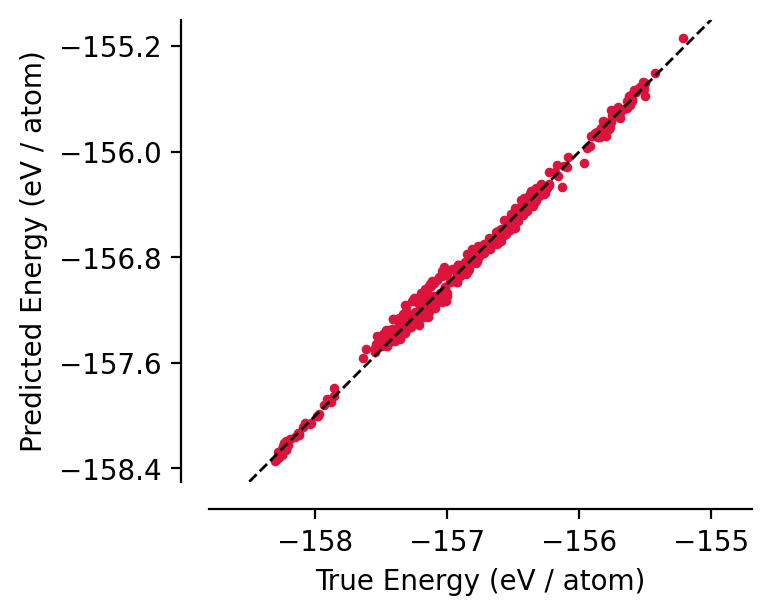

In [7]:
import matplotlib.pyplot as plt
from graph_pes.utils.analysis import parity_plot

%config InlineBackend.figure_format = 'retina'

parity_plot(
    best_model,
    test,
    property="energy_per_atom",
    units="eV / atom",
    lw=0,
    s=12,
    color="crimson",
)
plt.xlim(-158.5, -155)
plt.ylim(-158.5, -155);

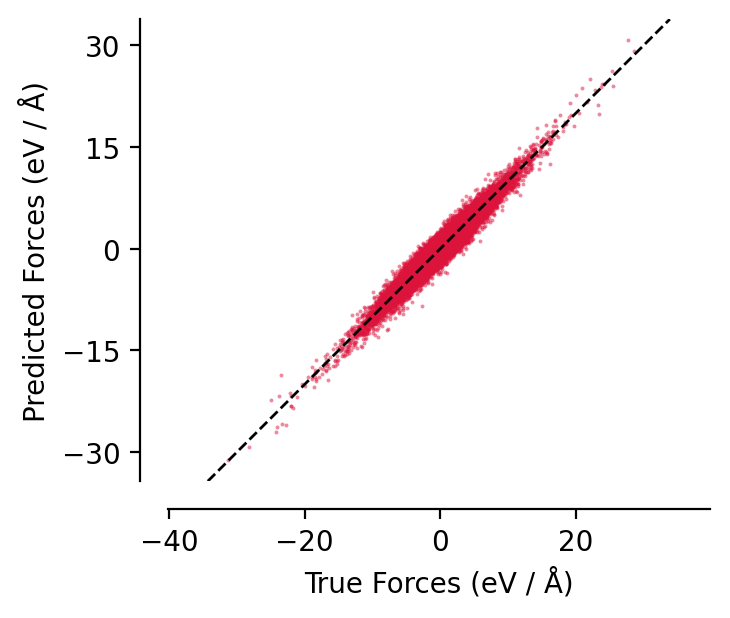

In [8]:
parity_plot(
    best_model,
    test,
    property="forces",
    units="eV / Å",
    lw=0,
    s=2,
    alpha=0.5,
    color="crimson",
)

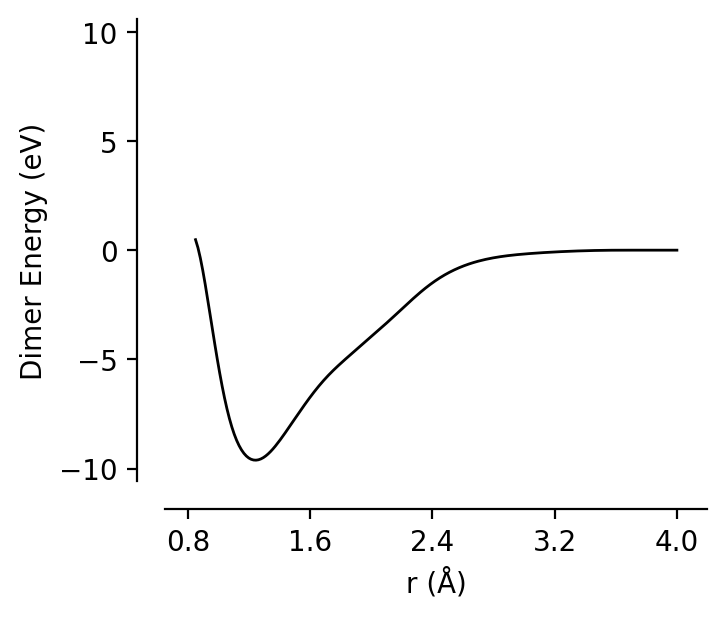

In [9]:
from graph_pes.utils.analysis import dimer_curve

dimer_curve(best_model, system="CC", units="eV", rmin=0.85, rmax=4.0);

Beyond static evaluations, there are many more use cases for these models - head over to e.g. our [ASE examples](https://jla-gardner.github.io/graph-pes/tools/ase.html) notebook for more details